In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('dark')
%matplotlib inline

In [2]:
cd ../deepsalience/

/scratch/rmb456/multif0/deepsalience


In [3]:
import multitask_evaluate as ME
from keras.models import load_model
import compute_training_data as CTD

Using TensorFlow backend.
/home/rmb456/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
# multitask vs single task
multitask_dir = '../experiment_output/multitask_base_experiment/'
multif0_dir = '../experiment_output/multitask_singletask_mf0/'
melody_dir = '../experiment_output/multitask_singletask_mel/'
bass_dir = '../experiment_output/multitask_singletask_bass/'
vocal_dir = '../experiment_output/multitask_singletask_vocal/'

# synth data vs no synth data
multitask_nosynth_dir = '../experiment_output/multitask_nosynth/'
multitask_nosynthguitar_dir = '../experiment_output/multitask_nosynthguitar/'

# freq vs no freq
multitask_freq_dir = '../experiment_output/multitask_freq_feature/'
multitask_freq_nosynth_dir = '../experiment_output/multitask_freq_nosynthdata/'
melody_freq_dir = '../experiment_output/multitask_singletask_mel_freq/'
bass_freq_dir = '../experiment_output/multitask_singletask_bass_freq/'
vocal_freq_dir = '../experiment_output/multitask_singletask_vocal_freq/'

# adjust number of tasks
mf0 = '../experiment_output/multitask_singletask_mf0/'
mf0_mel = '../experiment_output/multitask_mf0_melody/'
mf0_bass = '../experiment_output/multitask_mf0_bass/'
mf0_voc = '../experiment_output/multitask_mf0_vocal/'
mf0_mel_bass = '../experiment_output/multitask_mf0_mel_bass/'
mf0_mel_voc = '../experiment_output/multitask_mf0_mel_vocal/'
mf0_bass_voc = '../experiment_output/multitask_mf0_voc_bass/'
mf0_mel_bass_voc = '../experiment_output/multitask_base_experiment/'

# piano/guitar
mf0_piano = '../experiment_output/multitask_all_plus_piano/'
mf0_guitar = '../experiment_output/multitask_all_plus_guitar/'
mf0_piano_guitar = '../experiment_output/multitask_all_plus_piano_guitar/'

# number of harmonics
harms_5_dir = '../experiment_output/multitask_base_experiment/'
harms_4_dir = '../experiment_output/multitask_4harms/evaluation/'
harms_3_dir = '../experiment_output/multitask_3harms/evaluation/'
harms_2_dir = '../experiment_output/multitask_2harms/evaluation/'
harms_1_dir = '../experiment_output/multitask_1harms/evaluation/'

In [5]:
import mir_eval
import librosa
import sox
from scipy import signal

def plot_activations(model, layer_name, example):
    pass


def synth_tf(prediction, save_folder, save_name):
    sr = 8000
    frequencies = CTD.get_freq_grid()
    times = CTD.get_time_grid(prediction.shape[1])
    y = mir_eval.sonify.time_frequency(prediction, frequencies, times, sr, function=signal.square)
    temp_path = os.path.join(save_folder, "{}.wav".format(save_name))
    librosa.output.write_wav(temp_path, y, sr, norm=True)
    tfm = sox.Transformer()
    save_path = os.path.join(save_folder, "{}.aiff".format(save_name))
    tfm.build(temp_path, save_path)
    os.remove(temp_path)


def plot_prediction(model, npy_file, n_harms=5, sonify=True, annotation_file=None,
                    annot_type='single', delimiter='\t'):
    titles = ['multif0', 'melody', 'bass', 'vocal']
    prediction, x_in = ME.get_single_test_prediction(
        model, npy_file=npy_file, audio_file=None,
        max_frames=None, add_frequency=False, n_harms=n_harms
    )

    plt.figure(figsize=(15, 7))
    plt.subplot(2, 3, 1)
    plt.title("H[0]")
    plt.imshow(x_in[0, :, :, 0], origin='lower', cmap='magma', clim=[0, 1])
    plt.axis('off')
    plt.axis('tight')
    
    for i in range(4):
        plt.subplot(2, 3, i + 2)
        plt.title(titles[i])
        plt.imshow(prediction[i], origin='lower', cmap='magma', clim=[0, 1])
        plt.axis('off')
        plt.axis('tight')
    
    
    if annotation_file is not None:
        if annot_type == 'single':
            ref_times, ref_freqs = mir_eval.io.load_time_series(
                annotation_file, delimiter=delimiter)
        elif annot_type == 'multi':
            temp_times, temp_freqs = mir_eval.io.load_ragged_time_series(
                annotation_file, delimiter=delimiter)
            ref_times = []
            ref_freqs = []
            for t, f_arr in zip(temp_times, temp_freqs):
                for f in f_arr:
                    ref_times.append(t)
                    ref_freqs.append(f)

        plt.subplot(2, 3, 6)
        plt.title('annotation')
        plt.semilogy(ref_times, ref_freqs, ',', basey=2)
        plt.xlim([0, np.max(ref_times)])
        plt.ylim([32, 3000])
    
    plt.show()
    
    if sonify:
        save_base = os.path.basename(npy_file).split('.')[0]
        for i in range(4):
            save_name = "{}_{}".format(save_base, titles[i])
            synth_tf(prediction[i], "../../synthesized_output/", save_name)

In [6]:
cd mutlitask_experiments/

/scratch/rmb456/multif0/deepsalience/mutlitask_experiments


In [7]:
from multitask_base_experiment import get_model as mtask_gm
from multitask_singletask_mf0 import get_model as stask_mfo_gm
from multitask_singletask_melody import get_model as stask_mel_gm
from multitask_singletask_bass import get_model as stask_bas_gm
from multitask_singletask_vocal import get_model as stask_voc_gm

from multitask_all_plus_piano_guitar import get_model as mtask_six_gm

mtask_model = mtask_gm()
mtask_model.load_weights(
    "../../experiment_output/multitask_base_experiment/model_weights.h5")

stask_mfo_model = stask_mfo_gm()
stask_mfo_model.load_weights(
    "../../experiment_output/multitask_singletask_mf0/model_weights.h5")

stask_mel_model = stask_mel_gm()
stask_mel_model.load_weights(
    "../../experiment_output/multitask_singletask_mel/model_weights.h5")

stask_bass_model = stask_bas_gm()
stask_bass_model.load_weights(
    "../../experiment_output/multitask_singletask_bass/model_weights.h5")

stask_voc_model = stask_voc_gm()
stask_voc_model.load_weights(
    "../../experiment_output/multitask_singletask_vocal/model_weights.h5")

mtask_six_model = mtask_six_gm()
mtask_six_model.load_weights(
    "../../experiment_output/multitask_all_plus_piano_guitar/model_weights.h5")

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_1 (InputLayer)                   (None, None, None, 5)      0                                                     
________________________________________________________________________________________________________________________
pitch_layer1 (Conv2D)                  (None, None, None, 32)     4032                                                  
________________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormalizat (None, None, None, 32)     128                                                   
________________________________________________________________________________________________________________________
pitch_layer2 (Conv2D)           

In [8]:
def plot_mtask_v_single_task(multitask_model, mfo_model, mel_model, bass_model, voc_model,
                             npy_file, n_harms=5, annotation_file=None,
                             annot_type='single', delimiter='\t', max_frames=861):
    titles = ['Multi-$f_0$', 'Melody', 'Bass', 'Vocal']

    #multitask predictions
    mtask_prediction, x_in = ME.get_single_test_prediction(
        multitask_model, npy_file=npy_file, audio_file=None,
        max_frames=max_frames, add_frequency=False, n_harms=n_harms
    )

    for i in range(4):
        plt.subplot(2, 4, i + 1)
        plt.title(titles[i])
        plt.imshow(mtask_prediction[i], origin='lower', cmap='RdBu_r', vmin=-1, vmax=1)
        plt.axis('tight')
        if i == 0:
            plt.xticks([], [])
            plt.yticks([], [])
            plt.ylabel("Multitask")
        else:
            plt.axis('off')
    
    #singletask_predictions
    mf0_prediction, x_in = ME.get_single_test_prediction(
        mfo_model, npy_file=npy_file, audio_file=None,
        max_frames=max_frames, add_frequency=False, n_harms=n_harms
    )    
    
    plt.subplot(2, 4, 5)
    plt.imshow(mf0_prediction[0], origin='lower', cmap='RdBu_r', vmin=-1, vmax=1)
#     plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('tight')
    plt.ylabel("Single-task")
    
    mel_prediction, x_in = ME.get_single_test_prediction(
        mel_model, npy_file=npy_file, audio_file=None,
        max_frames=max_frames, add_frequency=False, n_harms=n_harms
    )
    
    plt.subplot(2, 4, 6)
    plt.imshow(mel_prediction[0], origin='lower', cmap='RdBu_r', vmin=-1, vmax=1)
    plt.axis('off')
    plt.axis('tight')
    
    bass_prediction, x_in = ME.get_single_test_prediction(
        bass_model, npy_file=npy_file, audio_file=None,
        max_frames=max_frames, add_frequency=False, n_harms=n_harms
    )
    
    plt.subplot(2, 4, 7)
    plt.imshow(bass_prediction[0], origin='lower', cmap='RdBu_r', vmin=-1, vmax=1)
    plt.axis('off')
    plt.axis('tight')
    
    voc_prediction, x_in = ME.get_single_test_prediction(
        voc_model, npy_file=npy_file, audio_file=None,
        max_frames=max_frames, add_frequency=False, n_harms=n_harms
    )
    
    plt.subplot(2, 4, 8)
    plt.imshow(voc_prediction[0], origin='lower', cmap='RdBu_r', vmin=-1, vmax=1)
    plt.axis('off')
    plt.axis('tight')
        
#     if annotation_file is not None:
#         if annot_type == 'single':
#             ref_times, ref_freqs = mir_eval.io.load_time_series(
#                 annotation_file, delimiter=delimiter)
#         elif annot_type == 'multi':
#             temp_times, temp_freqs = mir_eval.io.load_ragged_time_series(
#                 annotation_file, delimiter=delimiter)
#             ref_times = []
#             ref_freqs = []
#             for t, f_arr in zip(temp_times, temp_freqs):
#                 for f in f_arr:
#                     ref_times.append(t)
#                     ref_freqs.append(f)

#         plt.subplot(2, 3, 6)
#         plt.title('annotation')
#         plt.semilogy(ref_times, ref_freqs, ',', basey=2)
#         plt.xlim([0, np.max(ref_times)])
#         plt.ylim([32, 3000])


def plot_mtask_six(multitask_six_model, npy_file, n_harms=5, annotation_file=None,
                   annot_type='single', delimiter='\t', max_frames=861, sonify=True):
    titles = ['Multif0', 'Melody', 'Bass', 'Vocal', 'Piano', 'Guitar']

    #multitask predictions
    mtask_prediction, x_in = ME.get_single_test_prediction(
        multitask_six_model, npy_file=npy_file, audio_file=None,
        max_frames=max_frames, add_frequency=False, n_harms=n_harms
    )

    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.title(titles[i])
        plt.imshow(
            mtask_prediction[i], origin='lower', cmap='RdBu_r',
            vmin=-1.0*np.max(mtask_prediction[i]),
            vmax=np.max(mtask_prediction[i]))
        plt.axis('tight')
        plt.axis('off')

    if sonify:
        save_base = os.path.basename(npy_file).split('.')[0]
        for i in range(6):
            save_name = "{}_{}".format(save_base, titles[i])
            synth_tf(mtask_prediction[i], "../../outputs/sixtask_synth/", save_name)

In [9]:
import glob

test_path = "../../../multif0_ismir2017/multitask_test_data/"
bach10_path = os.path.join(test_path, "bach10")
ikala_path = os.path.join(test_path, "ikala")
mdb_mel_path = os.path.join(test_path, "medleydb_melody")
mdb_mf0_path = os.path.join(test_path, "medleydb_multif0")
orchset_path = os.path.join(test_path, "orchset")
su_path = os.path.join(test_path, "su")
maps_path = os.path.join(test_path, "maps")
weimar_jazz_mel = os.path.join(test_path, "weimar_jazz", "melody")
weimar_jazz_bass = os.path.join(test_path, "weimar_jazz", "bass")

In [10]:
TEST_DIR = '/scratch/rmb456/multif0_ismir2017/multitask_test_data/'

def get_test_files(test_set_name):
    if test_set_name in ['bach10', 'maps', 'medleydb_multif0', 'su']:
        test_dir = os.path.join(TEST_DIR, test_set_name)
        extension = 'txt'
    elif test_set_name in ['ikala', 'medleydb_melody', 'orchset']:
        test_dir = os.path.join(TEST_DIR, test_set_name)
        extension = 'csv'
    elif test_set_name == 'weimar_jazz_bass':
        test_dir = os.path.join(TEST_DIR, 'weimar_jazz', 'bass')
        extension = 'csv'
    elif test_set_name == 'weimar_jazz_melody':
        test_dir = os.path.join(TEST_DIR, 'weimar_jazz', 'melody')
        extension = 'csv'

    npy_files = glob.glob(os.path.join(test_dir, "*.npy"))
    test_files = []
    for npy_file in npy_files:
        if test_set_name in ['maps']:
            trackid = '_'.join(
                os.path.basename(npy_file).split('.')[0].split('_')[:3])
        else:
            trackid = '_'.join(
                os.path.basename(npy_file).split('.')[0].split('_')[:2])

        txt_file = glob.glob(
            os.path.join(test_dir, "{}*.{}".format(trackid, extension)))

        if len(txt_file) > 0:
            txt_file = txt_file[0]
            test_files.append([npy_file, txt_file])
        else:
            print('coudnt find text path')

    return test_files

In [11]:
def choose_random_example():    
    datasets = ['bach10', 'ikala', 'medleydb_melody', 'medleydb_multif0',
                'orchset', 'su', 'maps', 'weimar_jazz_melody', 'weimar_jazz_bass']
    annot_types = ['multi', 'single', 'single', 'multi', 'single', 'multi', 'multi', 'single', 'single']
    delimiters = ['\t', ',', ',', '\t', '\t', '\t', '\t', ',', ',']
    dataset_idx = np.random.choice(range(len(datasets)))
#     dataset_idx = 8
    dataset = datasets[dataset_idx]
    annot_type = annot_types[dataset_idx]
    delimiter = delimiters[dataset_idx]
    print(dataset)
    test_pairs = get_test_files(dataset)

#     for i, pair in enumerate(test_pairs):
#         print i
#         print(pair[0])
    
    test_idx = np.random.choice(range(len(test_pairs)))
#     test_idx = 16
    print(test_idx)
    #print(zip(range(len(test_pairs)), [os.path.basename(t1) for t1, t2 in test_pairs]))
    npy_file = test_pairs[test_idx][0]
    annotation_file = test_pairs[test_idx][1]
    return npy_file, annotation_file, annot_type, delimiter

su
4
/scratch/rmb456/multif0_ismir2017/multitask_test_data/su/PQ03_Farranc_audio_input.npy


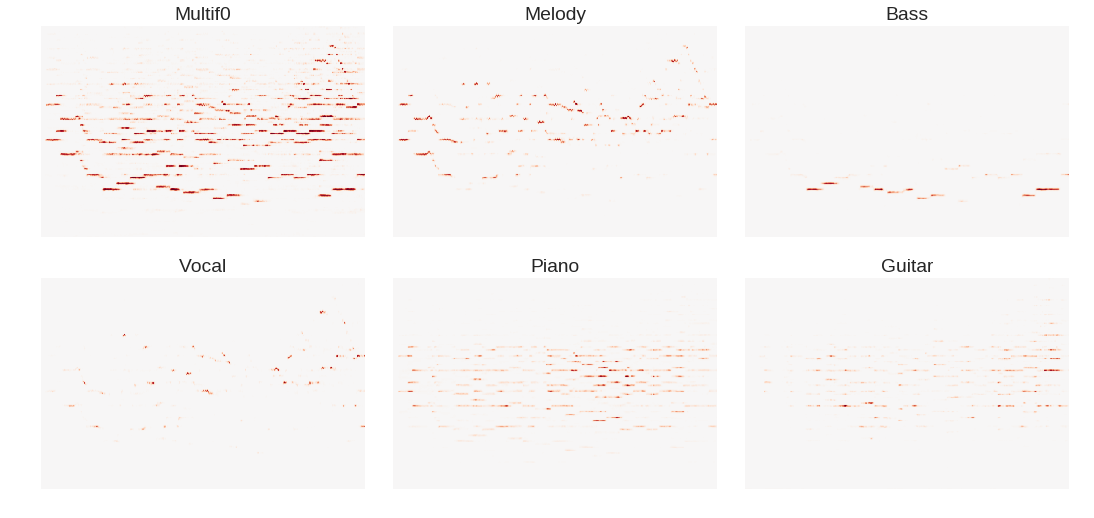

In [17]:
npy_file, annotation_file, annot_type, delimiter = choose_random_example()
print(npy_file)
sns.set(font_scale=1.6)
# plt.figure(figsize=(20, 7))
# plot_mtask_v_single_task(
#     mtask_model, stask_mfo_model, stask_mel_model,
#     stask_bass_model, stask_voc_model,
#     npy_file, delimiter=delimiter)
# plt.tight_layout(pad=0.0, w_pad=-1.3, h_pad=-0.7)
# savename = os.path.basename(npy_file).split('.')[0]
# plt.savefig(
#     "../../journal-paper-figs/mtask_stask_qual/{}.pdf".format(savename),
#     format='pdf', bbox_inches='tight')

plt.figure(figsize=(15, 7))
plot_mtask_six(mtask_six_model, npy_file, delimiter=delimiter, max_frames=8610)
plt.tight_layout(pad=0.0, w_pad=-1.2, h_pad=0.0)

# plt.savefig(
#     "../../journal-paper-figs/mtask_stask_qual/mtask_six_{}.pdf".format(savename),
#     format='pdf', bbox_inches='tight')

orchset
20
/scratch/rmb456/multif0_ismir2017/multitask_test_data/orchset/Musorgski_Ravel-PicturesExhibition-ex4_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/orchset/Musorgski_Ravel-PicturesExhibition-ex4.csv


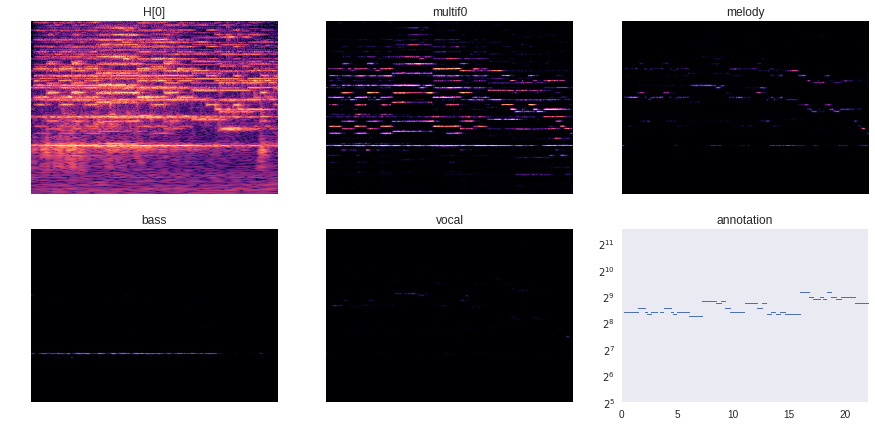

In [16]:
npy_file, annotation_file, annot_type, delimiter = choose_random_example()
print(npy_file)
print(annotation_file)
plot_prediction(
    model, npy_file, n_harms=5, sonify=False,
    annotation_file=annotation_file, annot_type=annot_type,
    delimiter=delimiter
)

In [12]:
def get_datapoints(dataset_name, folder):
    csv_path = os.path.join(folder, '{}_scores.csv'.format(dataset_name))
    df = pd.DataFrame.from_csv(csv_path)
    return df

In [13]:
multitask_dir = "../../experiment_output/multitask_base_experiment/evaluation/"

In [14]:
df = get_datapoints('orchset', multitask_dir)

In [15]:
df.sort_values('Raw Chroma Accuracy')

,Voicing Recall,Voicing False Alarm,Raw Pitch Accuracy,Raw Chroma Accuracy,Overall Accuracy,track
48,0.290984,0.269231,0.131148,0.392418,0.083658,Beethoven_S3-I-ex2_input
31,0.084451,0.025157,0.175360,0.415797,0.081031,Grieg_PeerGynt-HallMountainKing-ex1_input
0,0.243680,0.245000,0.296259,0.420121,0.204794,Dvorak_S9-IV-ex4_input
5,0.150078,0.000000,0.373250,0.422240,0.101236,Rimski_Korsakov-Scheherazade-Sea-SinbadShip-ex...
19,0.144633,0.100000,0.440530,0.447576,0.124538,Tchaikovsky_SwanLake-Scene-ex1_input
37,0.215853,0.082840,0.398443,0.457183,0.189001,Rimski_Korsakov-Scheherazade-Kalender-ex2_input
22,0.498176,0.254545,0.334028,0.471079,0.195035,Beethoven_S3-I-ex5_input
61,0.132713,0.000000,0.315723,0.522823,0.064718,Musorgski_Ravel-PicturesExhibition-ex11_input
27,0.102779,0.028302,0.368481,0.543967,0.097329,Ravel_Bolero-ex3_input
12,0.308793,0.125000,0.379346,0.552147,0.191617,Beethoven_S9-II-ex3_input
